## This Notebook contains Neural Network having Multiple Inputs and Single Output

In [1]:
# import the necessary packages
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import concatenate
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2

import os
import glob
import locale

### Load house attributes

In [2]:
# initialize the list of column names in the CSV file and then
# load it using Pandas
cols = ["bedrooms", "bathrooms", "area", "zipcode", "price"]

df = pd.read_csv("HousesInfo.txt", sep=" ", header=None, names=cols)

# determine (1) the unique zip codes and (2) the number of data
# points with each zip code
zipcodes = df["zipcode"].value_counts().keys().tolist()
counts = df["zipcode"].value_counts().tolist()

# loop over each of the unique zip codes and their corresponding
# count
for (zipcode, count) in zip(zipcodes, counts):
    # the zip code counts for our housing dataset is *extremely*
    # unbalanced (some only having 1 or 2 houses per zip code)
    # so let's sanitize our data by removing any houses with less
    # than 25 houses per zip code
    if count < 25:
        idxs = df[df["zipcode"] == zipcode].index
        df.drop(idxs, inplace=True)

In [3]:
df.head()

,bedrooms,bathrooms,area,zipcode,price
30,5,3.0,2520,93446,789000
32,3,2.0,1802,93446,365000
39,3,3.0,2146,93446,455000
80,4,2.5,2464,91901,599000
81,2,2.0,1845,91901,529800


### Load house images

In [4]:
# initialize our images array (i.e., the house images themselves)
images = []

# loop over the indexes of the houses
for i in df.index.values:
    # find the four images for the house and sort the file paths,
    # ensuring the four are always in the *same order*
    basePath = os.path.sep.join([".\Houses_Pics", "{}_*".format(i + 1)])
    #print(basePath)
    #continue
    housePaths = sorted(list(glob.glob(basePath)))

    # initialize our list of input images along with the output image
    # after *combining* the four input images
    inputImages = []
    outputImage = np.zeros((64, 64, 3), dtype="uint8")

    # loop over the input house paths
    for housePath in housePaths:
        # load the input image, resize it to be 32 32, and then
        # update the list of input images
        image = cv2.imread(housePath)
        image = cv2.resize(image, (32, 32))
        inputImages.append(image)

    # tile the four input images in the output image such the first
    # image goes in the top-right corner, the second image in the
    # top-left corner, the third image in the bottom-right corner,
    # and the final image in the bottom-left corner
    outputImage[0:32, 0:32] = inputImages[0]
    outputImage[0:32, 32:64] = inputImages[1]
    outputImage[32:64, 32:64] = inputImages[2]
    outputImage[32:64, 0:32] = inputImages[3]

    # add the tiled image to our set of images the network will be
    # trained on
    images.append(outputImage)
    
images = np.array(images) / 255.0

In [5]:
images[0].shape

(64, 64, 3)

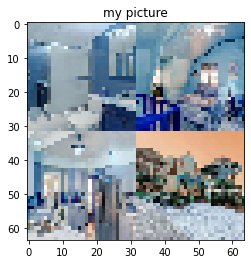

In [6]:
plt.figure(figsize=(12,4))
plt.imshow(images[0])
plt.title('my picture')
plt.show()

In [7]:
split = train_test_split(df, images, test_size=0.25, random_state=42)
(trainAttrX, testAttrX, trainImagesX, testImagesX) = split

In [8]:
# find the largest house price in the training set and use it to
# scale our house prices to the range [0, 1] (will lead to better
# training and convergence)
maxPrice = trainAttrX["price"].max()
trainY = trainAttrX["price"] / maxPrice
testY = testAttrX["price"] / maxPrice

In [9]:
# process the house attributes data by performing min-max scaling
# on continuous features, one-hot encoding on categorical features,
# and then finally concatenating them together

continuous = ["bedrooms", "bathrooms", "area"]

# performin min-max scaling each continuous feature column to
# the range [0, 1]
cs = MinMaxScaler()
trainContinuous = cs.fit_transform(trainAttrX[continuous])
testContinuous = cs.transform(testAttrX[continuous])

# one-hot encode the zip code categorical data (by definition of
# one-hot encoing, all output features are now in the range [0, 1])
zipBinarizer = LabelBinarizer().fit(df["zipcode"])
trainCategorical = zipBinarizer.transform(trainAttrX["zipcode"])
testCategorical = zipBinarizer.transform(testAttrX["zipcode"])

# construct our training and testing data points by concatenating
# the categorical features with the continuous features
trainAttrX = np.hstack([trainCategorical, trainContinuous])
testAttrX = np.hstack([testCategorical, testContinuous])

In [10]:
def create_mlp(dim, regress=False):
	# define our MLP network
	model = Sequential()
	model.add(Dense(8, input_dim=dim, activation="relu"))
	model.add(Dense(4, activation="relu"))

	# check to see if the regression node should be added
	if regress:
		model.add(Dense(1, activation="linear"))

	# return our model
	return model

def create_cnn(width, height, depth, filters=(16, 32, 64), regress=False):
	# initialize the input shape and channel dimension, assuming
	# TensorFlow/channels-last ordering
	inputShape = (height, width, depth)
	chanDim = -1

	# define the model input
	inputs = Input(shape=inputShape)

	# loop over the number of filters
	for (i, f) in enumerate(filters):
		# if this is the first CONV layer then set the input
		# appropriately
		if i == 0:
			x = inputs

		# CONV => RELU => BN => POOL
		x = Conv2D(f, (3, 3), padding="same")(x)
		x = Activation("relu")(x)
		x = BatchNormalization(axis=chanDim)(x)
		x = MaxPooling2D(pool_size=(2, 2))(x)

	# flatten the volume, then FC => RELU => BN => DROPOUT
	x = Flatten()(x)
	x = Dense(16)(x)
	x = Activation("relu")(x)
	x = BatchNormalization(axis=chanDim)(x)
	x = Dropout(0.5)(x)

	# apply another FC layer, this one to match the number of nodes
	# coming out of the MLP
	x = Dense(4)(x)
	x = Activation("relu")(x)

	# check to see if the regression node should be added
	if regress:
		x = Dense(1, activation="linear")(x)

	# construct the CNN
	model = Model(inputs, x)

	# return the CNN
	return model

In [11]:
# create the MLP and CNN models
mlp = create_mlp(trainAttrX.shape[1], regress=False)
cnn = create_cnn(64, 64, 3, regress=False)

In [12]:
#mlp.summary()

In [13]:
#cnn.summary()

In [14]:
# create the input to our final set of layers as the *output* of both
# the MLP and CNN
combinedInput = concatenate([mlp.output, cnn.output])
# our final FC layer head will have two dense layers, the final one
# being our regression head
x = Dense(4, activation="relu")(combinedInput)
x = Dense(1, activation="linear")(x)
# our final model will accept categorical/numerical data on the MLP
# input and images on the CNN input, outputting a single value (the
# predicted price of the house)
model = Model(inputs=[mlp.input, cnn.input], outputs=x)

In [15]:
#model.summary()

In [16]:
# compile the model using mean absolute percentage error as our loss,
# implying that we seek to minimize the absolute percentage difference
# between our price *predictions* and the *actual prices*
opt = Adam(lr=1e-3, decay=1e-3 / 2000)
model.compile(loss="mean_absolute_percentage_error", optimizer=opt)

In [17]:
#train the model
model.fit(
	[trainAttrX, trainImagesX], trainY,
	validation_data=([testAttrX, testImagesX], testY),
	epochs=200, batch_size=4)

Train on 271 samples, validate on 91 samples
Epoch 1/200
271/271 [==============================] - 3s 11ms/sample - loss: 346.3178 - val_loss: 126.3365
Epoch 2/200
271/271 [==============================] - 0s 2ms/sample - loss: 128.4374 - val_loss: 2588.4285
Epoch 3/200
271/271 [==============================] - 0s 2ms/sample - loss: 111.5119 - val_loss: 4258.7609
Epoch 4/200
271/271 [==============================] - 0s 2ms/sample - loss: 91.7075 - val_loss: 3581.8477
Epoch 5/200
271/271 [==============================] - 0s 2ms/sample - loss: 72.0731 - val_loss: 2404.2336
Epoch 6/200
271/271 [==============================] - 0s 2ms/sample - loss: 66.3612 - val_loss: 1537.3939
Epoch 7/200
271/271 [==============================] - 0s 2ms/sample - loss: 64.5371 - val_loss: 395.2994
Epoch 8/200
271/271 [==============================] - 0s 2ms/sample - loss: 65.9512 - val_loss: 77.1884
Epoch 9/200
271/271 [==============================] - 0s 2ms/sample - loss: 61.6486 - val_loss: 62

Epoch 78/200
271/271 [==============================] - 0s 2ms/sample - loss: 27.9898 - val_loss: 32.7890
Epoch 79/200
271/271 [==============================] - 0s 2ms/sample - loss: 29.6774 - val_loss: 27.7146
Epoch 80/200
271/271 [==============================] - 0s 2ms/sample - loss: 30.1706 - val_loss: 27.2775
Epoch 81/200
271/271 [==============================] - 0s 2ms/sample - loss: 28.4517 - val_loss: 28.9828
Epoch 82/200
271/271 [==============================] - 0s 2ms/sample - loss: 28.5836 - val_loss: 28.3650
Epoch 83/200
271/271 [==============================] - 1s 2ms/sample - loss: 29.1588 - val_loss: 27.3714
Epoch 84/200
271/271 [==============================] - 0s 2ms/sample - loss: 27.9530 - val_loss: 31.8740
Epoch 85/200
271/271 [==============================] - 0s 2ms/sample - loss: 28.6244 - val_loss: 27.7833
Epoch 86/200
271/271 [==============================] - 0s 2ms/sample - loss: 28.9511 - val_loss: 27.1198
Epoch 87/200
271/271 [========================

271/271 [==============================] - 0s 2ms/sample - loss: 27.0934 - val_loss: 84.1336
Epoch 155/200
271/271 [==============================] - 0s 2ms/sample - loss: 26.3040 - val_loss: 60.7458
Epoch 156/200
271/271 [==============================] - 0s 2ms/sample - loss: 28.1088 - val_loss: 31.3921
Epoch 157/200
271/271 [==============================] - 0s 2ms/sample - loss: 27.4778 - val_loss: 29.0454
Epoch 158/200
271/271 [==============================] - 0s 2ms/sample - loss: 28.4757 - val_loss: 27.7957
Epoch 159/200
271/271 [==============================] - 0s 2ms/sample - loss: 26.4689 - val_loss: 27.7350
Epoch 160/200
271/271 [==============================] - 0s 2ms/sample - loss: 27.4778 - val_loss: 27.6707
Epoch 161/200
271/271 [==============================] - 0s 2ms/sample - loss: 31.3760 - val_loss: 156.6311
Epoch 162/200
271/271 [==============================] - 0s 2ms/sample - loss: 28.4181 - val_loss: 35.8632
Epoch 163/200
271/271 [===========================

In [18]:
# make predictions on the testing data
preds = model.predict([testAttrX, testImagesX])

In [19]:
# compute the difference between the *predicted* house prices and the
# *actual* house prices, then compute the percentage difference and
# the absolute percentage difference
diff = preds.flatten() - testY
percentDiff = (diff / testY) * 100
absPercentDiff = np.abs(percentDiff)

In [20]:
# compute the mean and standard deviation of the absolute percentage
# difference
mean = np.mean(absPercentDiff)
std = np.std(absPercentDiff)

In [21]:
# finally, show some statistics on our model
locale.setlocale(locale.LC_ALL, "en_US.UTF-8")
print("[INFO] avg. house price: {}, std house price: {}".format(locale.currency(df["price"].mean(), grouping=True),
                                                                locale.currency(df["price"].std(), grouping=True)))
print("[INFO] mean: {:.2f}%, std: {:.2f}%".format(mean, std))

[INFO] avg. house price: $533,388.27, std house price: $493,403.08
[INFO] mean: 27.56%, std: 25.59%


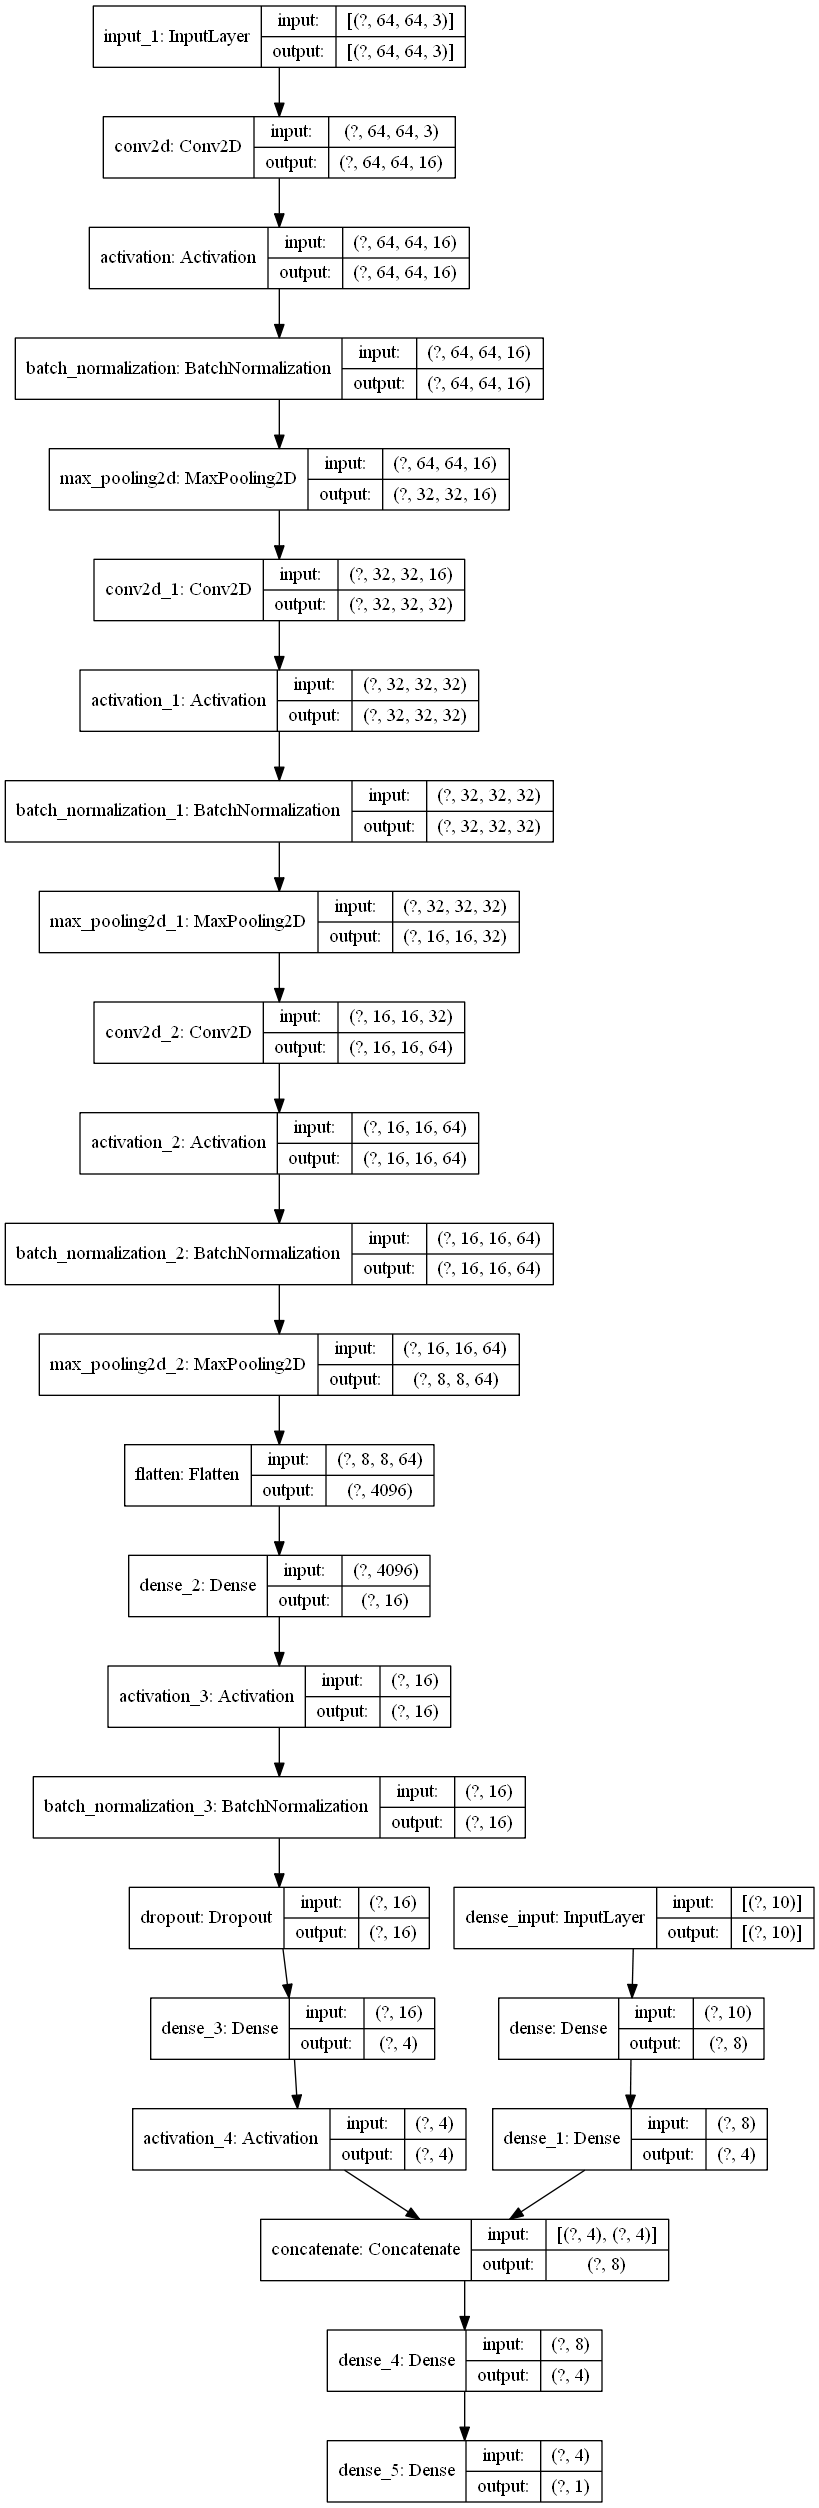

In [23]:
import tensorflow as tf
dot_img_file = 'MultiInput_Model.png'
tf.keras.utils.plot_model(model, to_file=dot_img_file, show_shapes=True)